In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import os

In [3]:
import ROOT
import h5py

In [4]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText

In [5]:
from uncertainties import ufloat, unumpy

In [6]:
def get_bin_sizes(bin_edges):
    return np.abs(np.diff(bin_edges))

In [7]:
TYPE = 14
NAME = r'gevgen_{0}'.format(TYPE)
CACHE = '/data/icecube/data/NuTeV/{0}/cache.hdf5'.format(TYPE)
DATA_NU = '/data/icecube/data/NuTeV/nutev_data/data/nutevpack/NuVec.dat'
DATA_NUBAR= '/data/icecube/data/NuTeV/nutev_data/data/nutevpack/NubarVec.dat'
Y_BINNING = np.array([0, 0.001, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.97, 1.0])
X_BINNING = np.array([0.0001, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
E_BINNING = np.array([30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 230, 260, 290, 320, 360])
Y_CENTERS = np.array([0.0005, 0.026, 0.075, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.935, 0.985])
X_CENTERS = np.array([0.015, 0.045, 0.08, 0.125, 0.175, 0.225, 0.275, 0.35, 0.45, 0.55, 0.65, 0.75])
E_CENTERS = np.array([35, 45, 55, 65, 75, 85, 95, 110, 130, 150, 170, 190, 215, 245, 275, 305, 340])
N_TARGET = 56
WA_NU = 0.677E-38# * N_TARGET
WA_NUBAR = 0.334E-38# * N_TARGET
print(WA_NU, WA_NUBAR)

6.77e-39 3.34e-39


In [8]:
is_cache = False
if os.path.isfile(CACHE):
    is_cache = True
print(is_cache)
if not is_cache:
    infile_nu = '/data/icecube/data/NuTeV/'+str(TYPE)+'/'+NAME+'.gst.root'
    infile_nubar = '/data/icecube/data/NuTeV/'+str(TYPE)+'/'+r'gevgen_-{0}.gst.root'.format(TYPE)
    input_file_nu = ROOT.TFile(infile_nu)
    input_file_nubar = ROOT.TFile(infile_nubar)
else:
    h5file = h5py.File(CACHE, 'r')
    for key in h5file.iterkeys():
        locals().update(dict([(key, np.array(h5file[key][:]))]))
    h5file.close()

True


In [9]:
def cache_events(in_arrays):
    h5file = h5py.File(CACHE, 'w')
    inarr_dict = dict(zip(STR_R, in_arrays))
    for key in inarr_dict.iterkeys():
        h5file.create_dataset(key, data=inarr_dict[key])
    h5file.close()

In [10]:
STR_R = ['pdg_array', 'energy_array', 'y_array', 'x_array', 'dis_array', 'cc_array']
if not is_cache:
    pdg_array, energy_array, y_array, x_array, dis_array, cc_array = [], [], [], [], [], []
    for event in input_file_nu.gst:
        pdg_array.append(event.neu)
        energy_array.append(event.Ev)
        y_array.append(event.y)
        x_array.append(event.x)
        dis_array.append(event.dis)
        cc_array.append(event.cc)
    for event in input_file_nubar.gst:
        pdg_array.append(event.neu)
        energy_array.append(event.Ev)
        y_array.append(event.y)
        x_array.append(event.x)
        dis_array.append(event.dis)
        cc_array.append(event.cc)
    pdg_array, energy_array, y_array, x_array, dis_array, cc_array = \
        map(np.array, (pdg_array, energy_array, y_array, x_array, dis_array, cc_array))
    cache_events((pdg_array, energy_array, y_array, x_array, dis_array, cc_array))
print(pdg_array.shape)

(2000000,)


In [11]:
invalid_entries = x_array < 0
discc = (dis_array & cc_array).astype(bool)
x_array = x_array[~invalid_entries & discc]
energy_array = energy_array[~invalid_entries & discc]
y_array = y_array[~invalid_entries & discc]
pdg_array = pdg_array[~invalid_entries & discc]
nu_mask = pdg_array > 0
nubar_mask = pdg_array < 0
print(r'{0} invalid entries'.format(np.sum(invalid_entries)))
print(r'{0} not discc'.format(np.sum(~discc)))

6286 invalid entries
576631 not discc


In [12]:
weights = np.ones(len(pdg_array))
a = 0.07581034
b = 1
a_bar = 0.10079423
b_bar = 1
#weights = np.power(x_array, -a) * b
#weights[nubar_mask] = np.power(x_array[nubar_mask], -a_bar) * b_bar
print(weights)
print(np.sum(weights) / len(weights))

[ 1.  1.  1. ...,  1.  1.  1.]
1.0


In [13]:
with open(DATA_NU, 'r') as f:
    table_nu = np.genfromtxt(f, usecols=range(9), skip_header=1)
with open(DATA_NUBAR, 'r') as f:
    table_nubar = np.genfromtxt(f, usecols=range(9), skip_header=1)

In [14]:
def decode_index(index):
    ybin = index % 100 - 1
    xbin = ((index % 10000) - ybin) / 100 - 1 - 1
    ebin = ((index % 1000000) - xbin*100 -ybin)/10000 - 1 - 1

    return [map(int, (ebin, xbin, ybin))]

nu_decoded_index, nubar_decoded_index = [], []
for index in table_nu[:,0]:
    nu_decoded_index.append(decode_index(index))
for index in table_nubar[:,0]:
    nubar_decoded_index.append(decode_index(index))
nu_decoded_index = np.vstack(nu_decoded_index)
nubar_decoded_index = np.vstack(nubar_decoded_index)
print(nu_decoded_index)

[[ 0  1  5]
 [ 0  1  6]
 [ 0  1  7]
 ..., 
 [16 11  2]
 [16 11  3]
 [16 11  4]]


In [15]:
nu_sys = table_nu[:,3:].T
nubar_sys = table_nubar[:,3:].T
print(nu_sys.shape)
nu_sys_err_2 = nu_sys[0]**2 + nu_sys[1]**2 + nu_sys[2]**2 + nu_sys[3]**2 + nu_sys[4]**2 + nu_sys[5]**2
nubar_sys_err_2 = nubar_sys[0]**2 + nubar_sys[1]**2 + nubar_sys[2]**2 + nubar_sys[3]**2 + nubar_sys[4]**2 + nubar_sys[5]**2
nu_xsec_array = unumpy.uarray(table_nu[:,1], np.sqrt(table_nu[:,2]**2 + nu_sys_err_2))
nubar_xsec_array = unumpy.uarray(table_nubar[:,1], np.sqrt(table_nubar[:,2]**2 + nubar_sys_err_2))

(6, 1423)


In [16]:
nu_data_matrix = np.zeros(map(len, (E_CENTERS, X_CENTERS, Y_CENTERS)))
nubar_data_matrix = np.zeros(map(len, (E_CENTERS, X_CENTERS, Y_CENTERS)))
nu_data_matrix, nubar_data_matrix = unumpy.uarray(nu_data_matrix, nu_data_matrix), \
                                    unumpy.uarray(nubar_data_matrix, nubar_data_matrix)
print(nu_data_matrix.shape)
for idx, entry in enumerate(nu_decoded_index):
    nu_data_matrix[tuple(entry)] = nu_xsec_array[idx]
for idx, entry in enumerate(nubar_decoded_index):
    nubar_data_matrix[tuple(entry)] = nubar_xsec_array[idx]
nu_data_matrix, nubar_data_matrix = ma.masked_equal(nu_data_matrix, 0), ma.masked_equal(nubar_data_matrix, 0)

(17, 12, 13)


In [17]:
def make_histo(array, weights):
    hist, edges = np.histogram(array, bins=Y_BINNING, weights=weights)
    hist_2, edges = np.histogram(array, bins=Y_BINNING, weights=weights**2)

    u_hist = unumpy.uarray(hist, np.sqrt(hist_2))
    return ma.masked_equal(u_hist, 0)

In [18]:
e_bin_sizes = get_bin_sizes(E_BINNING).astype(float)
x_bin_sizes = get_bin_sizes(X_BINNING).astype(float)
y_bin_sizes = get_bin_sizes(Y_BINNING).astype(float)

NU_HISTOGRAMS = unumpy.uarray(np.zeros(map(len, (e_bin_sizes, x_bin_sizes, y_bin_sizes))).astype(float),
                              np.zeros(map(len, (e_bin_sizes, x_bin_sizes, y_bin_sizes))).astype(float))
NUBAR_HISTOGRAMS = unumpy.uarray(np.zeros(map(len, (e_bin_sizes, x_bin_sizes, y_bin_sizes))).astype(float),
                                 np.zeros(map(len, (e_bin_sizes, x_bin_sizes, y_bin_sizes))).astype(float))
SCALING_NU, SCALING_NUBAR = [], []
for e_idx, e_bin in enumerate(E_BINNING[:-1]):
    energy_mask = (energy_array >= e_bin) & (energy_array < E_BINNING[e_idx + 1])
    weights_e = weights[energy_mask]
    y_array_e = y_array[energy_mask]
    x_array_e = x_array[energy_mask]
    nu_mask_e = nu_mask[energy_mask]
    nubar_mask_e = nubar_mask[energy_mask]
    
    sigma_nu = sigma_nubar = 0
    NU_HISTOGRAMS[e_idx], NUBAR_HISTOGRAMS[e_idx] = {}, {}
    for x_idx, x_bin in enumerate(X_BINNING[:-1]):
        x_mask = (x_array_e >= x_bin) & (x_array_e < X_BINNING[x_idx+1])
        y_array_e_x = y_array_e[x_mask]
        weights_e_x = weights_e[x_mask]
        nu_mask_e_x = nu_mask_e[x_mask]
        nubar_mask_e_x = nubar_mask_e[x_mask]

        sigma_nu_x_nw = make_histo(
            y_array_e_x[nu_mask_e_x], np.ones(weights_e_x[nu_mask_e_x].shape)
        )
        sigma_nu_x = make_histo(
            y_array_e_x[nu_mask_e_x], weights_e_x[nu_mask_e_x]
        )
        sigma_nu_x_e_nw = sigma_nu_x_nw * (1 / E_CENTERS[e_idx].astype(float))
        sigma_nu_x_e = sigma_nu_x * (1 / E_CENTERS[e_idx].astype(float))
        
        sigma_nubar_x_nw = make_histo(
            y_array_e_x[nubar_mask_e_x], np.ones(weights_e_x[nubar_mask_e_x].shape)
        )
        sigma_nubar_x = make_histo(
            y_array_e_x[nubar_mask_e_x], weights_e_x[nubar_mask_e_x]
        )
        sigma_nubar_x_e_nw = sigma_nubar_x_nw * (1 / E_CENTERS[e_idx].astype(float))
        sigma_nubar_x_e = sigma_nubar_x * (1 / E_CENTERS[e_idx].astype(float))
        
        factors = 1 / (y_bin_sizes * x_bin_sizes[x_idx])
        NU_HISTOGRAMS[e_idx][x_idx] = sigma_nu_x_e * factors
        NUBAR_HISTOGRAMS[e_idx][x_idx] = sigma_nubar_x_e * factors
        sigma_nu += np.sum(unumpy.nominal_values(sigma_nu_x_e_nw.data))# * factors)
        sigma_nubar += np.sum(unumpy.nominal_values(sigma_nubar_x_e_nw.data))# * factors)

    SCALING_NU.append((WA_NU / 1E-38) / sigma_nu)
    SCALING_NUBAR.append((WA_NUBAR / 1E-38) / sigma_nubar)
SCALING_NU, SCALING_NUBAR = map(ma.masked_invalid, (SCALING_NU, SCALING_NUBAR))
NU_HISTOGRAMS = ma.masked_equal(NU_HISTOGRAMS, 0)
NUBAR_HISTOGRAMS = ma.masked_equal(NUBAR_HISTOGRAMS, 0)
print(SCALING_NU)
print(SCALING_NUBAR)

[0.00035048145902051564 0.0005587652690656982 0.0008313982047961418
 0.0011751275135524874 0.0015090049928673326 0.0019354567469393247
 0.0024373744646985266 0.0016236073865742258 0.002274512844368636
 0.0029170137592278754 0.0039010914514270223 0.005037794227078684
 0.004164544648221796 0.005241262718827022 0.006850713865175154
 0.008368186423505574 0.007729089016487023]
[0.00019144476106252662 0.0003050104511232421 0.0004461120015542281
 0.0006235638786764705 0.0008037089322381929 0.0010193529855301428
 0.0012828495188808926 0.0008510342591091245 0.0011834932402965544
 0.0015417756577935067 0.002031194104600415 0.002563108364635082
 0.002141983594332588 0.0026787351054078827 0.0035152512533966093
 0.004343951217432094 0.004001973498731323]


In [19]:
c = np.array([0.00025451674579475396, 0.0004110614871884825, 0.0006157904311442605,
 0.0008744684233536028, 0.0011263059825647168, 0.0014416163539344145,
 0.001828637229535697, 0.0012190011622006515, 0.001725314147928878,
 0.0022150242114906426, 0.0029641744147114128, 0.003796074959421574,
 0.003155800793530343, 0.003977101067018343, 0.005210024066715174,
 0.00634928200239845, 0.005895249071584069])
d = np.array([0.00022330976992361812, 0.00035974576452309795, 0.0005376193912566737,
 0.0007625963842036274, 0.0009809746114180897, 0.0012542913280845689,
 0.0015892899072450595, 0.0010581578368362772, 0.0014961698102798958,
 0.0019172224576717981, 0.002562088777538678, 0.0032793358954471843,
 0.0027205928040509066, 0.003426837386445279, 0.0044838868452545455,
 0.005462631780338485, 0.005063805325970521])
print(d/c)
np.sum(d/c) / float(len(d))

[ 0.87738734  0.8751629   0.87305577  0.87206852  0.87096635  0.87005903
  0.86911164  0.86805318  0.86718689  0.86555373  0.86435156  0.86387543
  0.86209269  0.86164202  0.8606269   0.86035425  0.85896376]


0.8670889394981961

In [20]:
def format_axis(ax, binning, x_label=r'', title=r'', lhs=False, ylim=None):
    ax.set_title(title)

    ax.set_xlim(np.min(binning), np.max(binning))
    for xmaj in binning:
        ax.axvline(x=xmaj, ls=':', color='gray', alpha=0.4, linewidth=1)
    if x_label == r'':
        ax.get_xaxis().set_ticks([])
    else:
        ax.set_xlabel(x_label, fontsize=14)

    ax.tick_params(axis='y', labelsize=10)
    if not ylim is None:
        ax.set_ylim(ylim)
    #ax.set_ylim(1, 7000)
    #ax.set_yscale('log')
    for ymaj in ax.yaxis.get_majorticklocs():
        ax.axhline(y=ymaj, ls=':', color='gray', alpha=0.4, linewidth=1)
    if not lhs:
        ax.get_yaxis().set_ticks([])
        xticks = ax.xaxis.get_major_ticks()
        try:
            xticks[0].set_visible(False)
        except:
            pass
    else:
        yticks = ax.yaxis.get_major_ticks()
        for yt in yticks:
            yt.label.set_fontsize(9)
        yticks[0].set_visible(False)


def plot_histo(ax, binning, centers, histo, colour):
    histo_0 = np.concatenate(([histo[0]], histo))
    ax.step(
        binning, unumpy.nominal_values(histo_0),
        alpha=0.5, color=colour, drawstyle='steps-pre', linewidth=2, linestyle=':'
    )
    ax.errorbar(
        centers, unumpy.nominal_values(histo),
        xerr=0, yerr=unumpy.std_devs(histo),
        capsize=0.7, alpha=1, color=colour, linestyle='None', markersize=0.5, linewidth=1
    )

    
def plot_data(ax, centers, array, colour):
    ax.errorbar(
        centers, unumpy.nominal_values(array), xerr=0, yerr=unumpy.std_devs(array),
        capsize=1.5, alpha=1, color=colour, linestyle='-', markersize=3, linewidth=0.4
    )

WA nu/nubar 6.77e-39 3.34e-39
E: 9, 150


/.data/mandalia/programs/anaconda2/envs/pisa/lib/python2.7/site-packages/ipykernel/__main__.py:39: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/.data/mandalia/programs/anaconda2/envs/pisa/lib/python2.7/site-packages/ipykernel/__main__.py:40: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


nu/nubar integral = 3.90260940927e-39 2.07475434621e-39


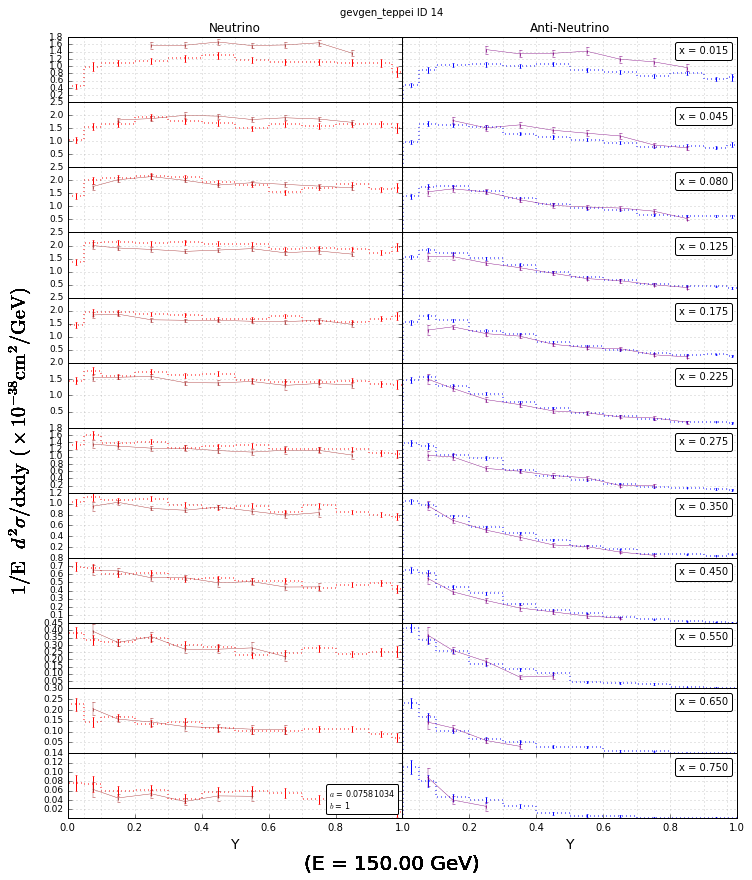

In [23]:
#E_PLOT = None
E_PLOT = [150]

x_bin_sizes = get_bin_sizes(X_BINNING).astype(float)
y_bin_sizes = get_bin_sizes(Y_BINNING).astype(float)
print('WA nu/nubar {0} {1}'.format(WA_NU, WA_NUBAR))
for e_idx, e_bin in enumerate(E_BINNING[:-1]):
    e_cont = True
    if E_PLOT is None:
        e_cont = False
    else:
        for x in E_PLOT:
            if x >= e_bin and x < E_BINNING[e_idx + 1]:
                e_cont = False
    if e_cont:
        continue
    print(r'E: {0}, {1}'.format(e_idx, E_CENTERS[e_idx]))

    fig = plt.figure(figsize=[12, 14])
    fig.suptitle('gevgen_teppei ID {0}'.format(TYPE), y=0.93)
    gs = gridspec.GridSpec(len(X_CENTERS), 1)
    gs.update(hspace=0., wspace=0.)

    nu_int = 0
    nubar_int = 0
    for x_idx, x_bin in enumerate(X_BINNING[:-1]):
        gs0 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[x_idx],
                                               wspace=0, hspace=0, width_ratios=[1,1])

        ax0 = fig.add_subplot(gs0[0])

        plot_histo(ax0, Y_BINNING, Y_CENTERS, NU_HISTOGRAMS[e_idx][x_idx] * SCALING_NU[e_idx], colour='red')
        plot_data(ax0, Y_CENTERS, nu_data_matrix[e_idx][x_idx], colour='brown')
            
        ax1 = fig.add_subplot(gs0[1])
        plot_histo(ax1, Y_BINNING, Y_CENTERS, NUBAR_HISTOGRAMS[e_idx][x_idx] * SCALING_NUBAR[e_idx], colour='blue')
        plot_data(ax1, Y_CENTERS, nubar_data_matrix[e_idx][x_idx], colour='purple')

        nu_int += np.sum(NU_HISTOGRAMS[e_idx][x_idx].data * y_bin_sizes) * SCALING_NU[e_idx] * x_bin_sizes[x_bin]
        nubar_int += np.sum(NUBAR_HISTOGRAMS[e_idx][x_idx].data * y_bin_sizes) * SCALING_NUBAR[e_idx] * x_bin_sizes[x_bin]

        ylim = (np.min([ax0.get_ylim()[0], ax1.get_ylim()[0]]),
                np.max([ax0.get_ylim()[1], ax1.get_ylim()[1]]))
        #ylim = (0, 10)
        ax0.set_ylim(ylim)
        ax1.set_ylim(ylim)
        #ax1.set_ylim(ax0.get_ylim())
        if x_idx == 0:
            format_axis(ax0, Y_BINNING, title=r'Neutrino', lhs=True)
            format_axis(ax1, Y_BINNING, title=r'Anti-Neutrino')
            
        elif x_idx == len(X_CENTERS)-1:
            format_axis(ax0, Y_BINNING, x_label=r'Y', lhs=True)
            format_axis(ax1, Y_BINNING, x_label=r'Y')
            
            at0 = AnchoredText(r'$a$ = {0}'.format(a)+'\n'+r'$b$ = {0}'.format(b),
                               prop=dict(size=8), frameon=True, loc=4)
            at0.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
            ax0.add_artist(at0)
        else:
            format_axis(ax0, Y_BINNING, lhs=True)
            format_axis(ax1, Y_BINNING)
        
        at = AnchoredText(r'x = {0:.3f}'.format(X_CENTERS[x_idx]),
                          prop=dict(size=10), frameon=True, loc=1)
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax1.add_artist(at)
        
        fig.text(0.055, 0.5, r'$\rm{1/E}$  $d^2\sigma/\rm{dx dy}$ $(\times 10^{-38}\rm{cm}^2/\rm{GeV})$',
                 rotation='vertical', va='center', size=20)
        fig.text(0.5, 0.075, r'(E = {0:.2f} GeV)'.format(E_CENTERS[e_idx]), ha='center', size=20)
    
    print('nu/nubar integral = {0} {1}'.format(nu_int.n * 1E-38, nubar_int.n * 1E-38))
    #fig.savefig('./images/NuTeV/gevgen/x/'+NAME+'_'+'{0:06.2f}_alt.png'.format(E_CENTERS[e_idx]), bbox_inches='tight')

WA nu/nubar 6.77e-39 3.34e-39
E: 9, 150


/.data/mandalia/programs/anaconda2/envs/pisa/lib/python2.7/site-packages/ipykernel/__main__.py:39: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/.data/mandalia/programs/anaconda2/envs/pisa/lib/python2.7/site-packages/ipykernel/__main__.py:40: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


nu/nubar integral = 1.60658712257e-40 7.10524416468e-41


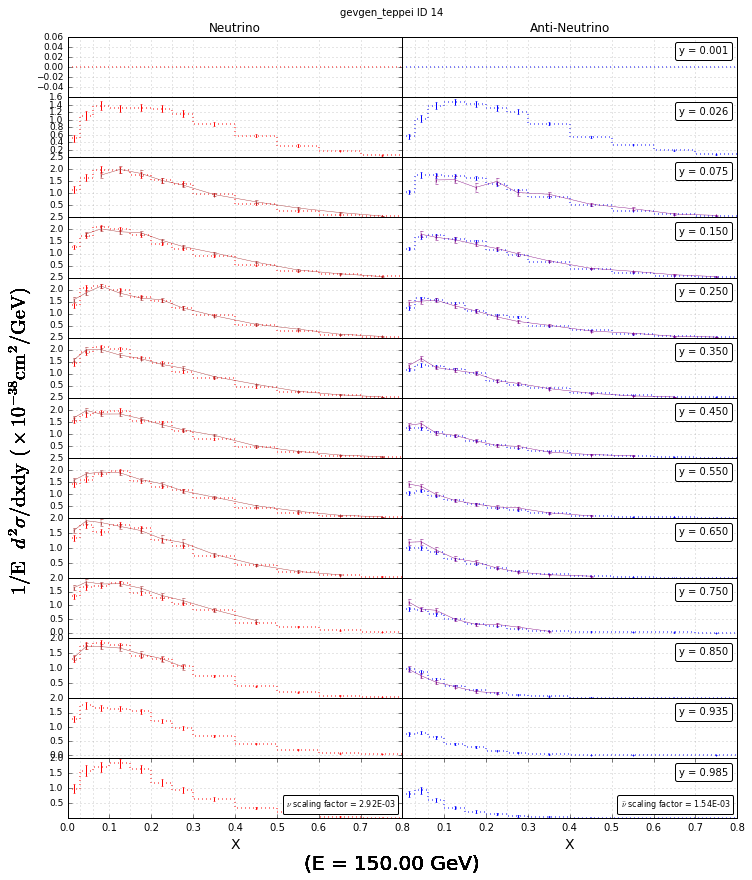

In [63]:
#E_PLOT = None
E_PLOT = [150]

x_bin_sizes = get_bin_sizes(X_BINNING).astype(float)
y_bin_sizes = get_bin_sizes(Y_BINNING).astype(float)
print('WA nu/nubar {0} {1}'.format(WA_NU, WA_NUBAR))
for e_idx, e_bin in enumerate(E_BINNING[:-1]):
    e_cont = True
    if E_PLOT is None:
        e_cont = False
    else:
        for x in E_PLOT:
            if x >= e_bin and x < E_BINNING[e_idx + 1]:
                e_cont = False
    if e_cont:
        continue
    print(r'E: {0}, {1}'.format(e_idx, E_CENTERS[e_idx]))

    fig = plt.figure(figsize=[12, 14])
    fig.suptitle('gevgen_teppei ID {0}'.format(TYPE), y=0.93)
    gs = gridspec.GridSpec(len(Y_CENTERS), 1)
    gs.update(hspace=0., wspace=0.)

    nu_int = 0
    nubar_int = 0
    for y_idx, y_bin in enumerate(Y_BINNING[:-1]):
        gs0 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[y_idx],
                                               wspace=0, hspace=0, width_ratios=[1,1])

        ax0 = fig.add_subplot(gs0[0])

        plot_histo(ax0, X_BINNING, X_CENTERS, NU_HISTOGRAMS[e_idx][:,y_idx] * SCALING_NU[e_idx], colour='red')
        plot_data(ax0, X_CENTERS, nu_data_matrix[e_idx][:,y_idx], colour='brown')

        ax1 = fig.add_subplot(gs0[1])
        plot_histo(ax1, X_BINNING, X_CENTERS, NUBAR_HISTOGRAMS[e_idx][:,y_idx] * SCALING_NUBAR[e_idx], colour='blue')
        plot_data(ax1, X_CENTERS, nubar_data_matrix[e_idx][:,y_idx], colour='purple')

        nu_int += np.sum(NU_HISTOGRAMS[e_idx][x_idx].data * y_bin_sizes) * SCALING_NU[e_idx] * x_bin_sizes[x_bin]
        nubar_int += np.sum(NUBAR_HISTOGRAMS[e_idx][x_idx].data * y_bin_sizes) * SCALING_NUBAR[e_idx] * x_bin_sizes[x_bin]

        ylim = (np.min([ax0.get_ylim()[0], ax1.get_ylim()[0]]),
                np.max([ax0.get_ylim()[1], ax1.get_ylim()[1]]))
        #ylim = (0, 10)
        ax0.set_ylim(ylim)
        ax1.set_ylim(ylim)
        #ax1.set_ylim(ax0.get_ylim())
        if y_idx == 0:
            format_axis(ax0, X_BINNING, title=r'Neutrino', lhs=True)
            format_axis(ax1, X_BINNING, title=r'Anti-Neutrino')
        elif y_idx == len(Y_CENTERS)-1:
            format_axis(ax0, X_BINNING, x_label=r'X', lhs=True)
            format_axis(ax1, X_BINNING, x_label=r'X')
            
            at0 = AnchoredText(r'$\nu$ scaling factor = {0:.2E}'.format(SCALING_NU[e_idx]),
                               prop=dict(size=8), frameon=True, loc=4)
            at0.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
            ax0.add_artist(at0)
            
            at1 = AnchoredText(r'$\bar\nu$ scaling factor = {0:.2E}'.format(SCALING_NUBAR[e_idx]),
                               prop=dict(size=8), frameon=True, loc=4)
            at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
            ax1.add_artist(at1)
        else:
            format_axis(ax0, X_BINNING, lhs=True)
            format_axis(ax1, X_BINNING)

        at = AnchoredText(r'y = {0:.3f}'.format(Y_CENTERS[y_idx]),
                          prop=dict(size=10), frameon=True, loc=1)
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax1.add_artist(at)

        fig.text(0.055, 0.5, r'$\rm{1/E}$  $d^2\sigma/\rm{dx dy}$ $(\times 10^{-38}\rm{cm}^2/\rm{GeV})$',
                 rotation='vertical', va='center', size=20)
        fig.text(0.5, 0.075, r'(E = {0:.2f} GeV)'.format(E_CENTERS[e_idx]), ha='center', size=20)

    print('nu/nubar integral = {0} {1}'.format(nu_int.n * 1E-38, nubar_int.n * 1E-38))
    #fig.savefig('./images/NuTeV/gevgen/y/'+NAME+'_'+'{0:06.2f}_alt.png'.format(E_CENTERS[e_idx]), bbox_inches='tight')